In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from math import sqrt

# copies of dataframe read in so that maximum non-na values can be extracted from each column
df_rect = pd.read_csv("C:\\Users\\Ronald\\Documents\\EECS_738\\Projects\\Probably_Interesting_Data\\horse.csv")
df_pulse = pd.read_csv("C:\\Users\\Ronald\\Documents\\EECS_738\\Projects\\Probably_Interesting_Data\\horse.csv")
df_resp = pd.read_csv("C:\\Users\\Ronald\\Documents\\EECS_738\\Projects\\Probably_Interesting_Data\\horse.csv")
df_pcv = pd.read_csv("C:\\Users\\Ronald\\Documents\\EECS_738\\Projects\\Probably_Interesting_Data\\horse.csv")

### Look at data features

In [2]:
df_rect.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


### Look at the distribution of points for various features. Drop all 'na' values

In [3]:
df_rect.dropna(subset=['rectal_temp'], inplace=True)
df_rect.reset_index(drop=True, inplace=True)
rectal_temp = df_rect['rectal_temp']

df_pulse.dropna(subset=['pulse'], inplace=True)
df_pulse.reset_index(drop=True, inplace=True)
pulse = df_pulse['pulse']

df_resp.dropna(subset=['respiratory_rate'], inplace=True)
df_resp.reset_index(drop=True, inplace=True)
respiratory_rate = df_resp['respiratory_rate']

df_pcv.dropna(subset=['packed_cell_volume'], inplace=True)
df_pcv.reset_index(drop=True, inplace=True)
packed_cell_volume = df_pcv['packed_cell_volume']

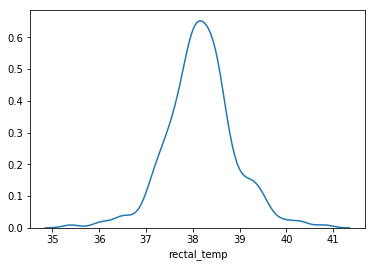

In [4]:
sns.distplot(rectal_temp, hist=False)

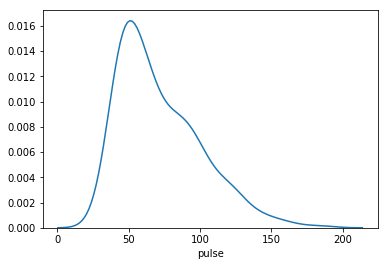

In [5]:
sns.distplot(pulse, hist=False)

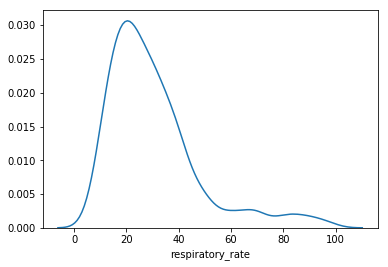

In [6]:
sns.distplot(respiratory_rate, hist=False)

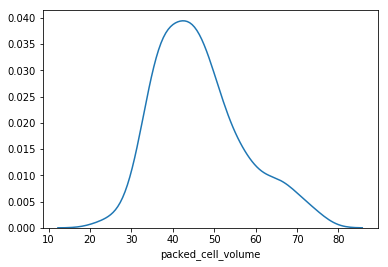

In [7]:
sns.distplot(packed_cell_volume, hist=False)

### From the plots above, it can be seen that these are not pure gaussian models, but rather mixtures of gaussian models.

### It also can be observed that a gaussian mixture model composed of 2 gaussians (k = 2) would be a good fit for these distributions.

### Our goal is to find the number of models that provides the best mixtures.

In [8]:
# create a simple gaussian model
def gaussian(x, mu, sigma):
    y = np.asarray(x)
    p = norm.pdf(y,mu,sigma)
    return p

In [9]:
# convergence criterion test for the gaussian mixture model
# criterion if the updated values of mu and sigma have not increased by more than .01, then the EM algorithm has converged
def convergence_test(mu, mu_prev, sig, sig_prev):
    k = len(mu)
    mu_diff = []
    sig_diff = []
    
    # compute difference between updated and previous values for mu and sigma
    for i in range(k):
        mu_diff.append(abs(mu[i]-mu_prev[i]))
        sig_diff.append(abs(sig[i]-sig_prev[i]))
    
    # check if values of the differences meet the criterion
    mu_count = 0
    sig_count = 0
    for i in range(k):
        if(mu_diff[i] < .01):
            mu_count = mu_count + 1
        if(sig_diff[i] < .01):
            sig_count = sig_count + 1
    
    if(mu_count == k and sig_count == k):
        return True
    else:
        return False

In [10]:
# create plot function for gaussian model
def plot_gaussian(x, z, title):
    z.sort()
    x2, y2 = zip(*z)
    # plot subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    sns.distplot(x, hist=False, ax=ax1)
    ax1.set_title(title + " Probability Distribution")
    ax2.plot(x2,y2)
    ax2.set_title(title + " GMM")

### Create a gaussian mixture model using the expectation-maximization (EM) algorithm

### Arbitrarily choose mu values by looking at original graph

### Mu values for each distribution will be stored in a dictionary that can be passed into the gaussian mixture model

In [11]:
def gaussian_mixture_model(x, d, title):
    # initialize values of means, variances, and mixture coefficients of gaussian models
    N = len(x)
    k = d['k']
    mix = 1/k
    mu = d['mu']
    mu_prev = []
    sig = d['sig']
    sig_prev = []
    pi_k = []
    pi_k_prev = []
    lat = []
    gaus = []
    
    # pick good starting values for mu and sig
    
    for i in range(k):
        mu_prev.append(100)
        sig.append(10)
        sig_prev.append(100)
        pi_k.append(mix)
        lat.append([0] * N)
        
    # initialize guassian variable
    for i in range(k):
        gaus.append(gaussian(x, mu[i], sig[i]))
        
    # repeat E-step and M-step until convergence criterion met
    count = 0
    
    # convergence criterion for EM algorithm
    while(not convergence_test(mu, mu_prev, sig, sig_prev) or count < 50):
        # E-step 
        # compute the values of the latent variables
        for i in range(k):
            for j in range(N):
                lat_total = 0
                for l in range(k):
                    lat_total = lat_total + pi_k[l]*gaus[l][j]
                lat[i][j] = pi_k[i]*gaus[i][j]/lat_total
                
        # store prev values of means, variances for convergence testing
        mu_prev = mu.copy()
        sig_prev = sig.copy()
        pi_k_prev = pi_k.copy()
        
        
        # M-step    
        # update the values of the means, variances, and mixing cofficient
        for i in range(k):
            mu_sum = 0
            sig_sum = 0
            pi_sum = 0
            for j in range(N):
                mu_sum = mu_sum + (x[j] * lat[i][j])/sum(lat[i])
                sig_sum = sig_sum + ((x[j]-mu[i])**2 * lat[i][j])/sum(lat[i])
                pi_sum = pi_sum + lat[i][j]/N
            mu[i] = mu_sum
            sig[i] = sqrt(sig_sum)
            pi_k[i] = pi_sum
        
        # update gaussian models
        for i in range(k):
            gaus[i] = gaussian(x, mu[i] ,sig[i])
        
        # increase iteration
        count = count + 1
    
    # responsibilities for each sample
    resp = [ list(x) for x in zip(*lat)]
    
    y = []
    
    for i in range(N):
        p_sum = 0
        for j in range(k):
            p_sum = p_sum + pi_k[j]*gaus[j][i]
        y.append(p_sum)

    z = list(zip(x,y))
    
    # plot function
    plot_gaussian(x, z, title)
    
    return

### Test the GMM model on various features at the value k = 2

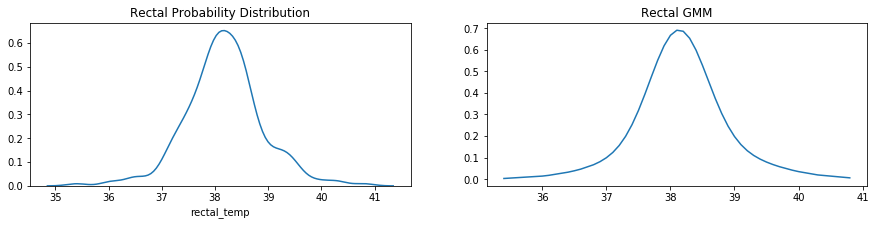

In [12]:
#rectal temperature feature
d1 = {'k':2, 'mu':[38.0,39.5], 'sig':[10,10]}
y1 = gaussian_mixture_model(rectal_temp, d1, "Rectal")

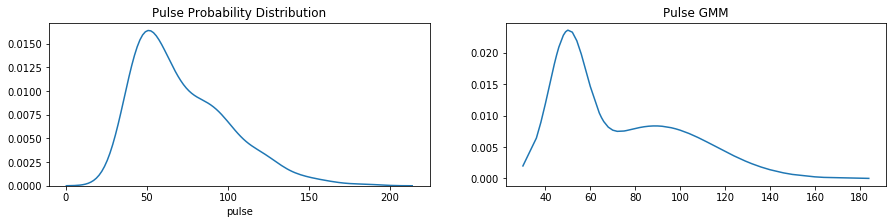

In [13]:
# pulse feature
d2 = {'k':2, 'mu':[50.0, 85.0], 'sig':[10,10]}
y2 = gaussian_mixture_model(pulse, d2, "Pulse")

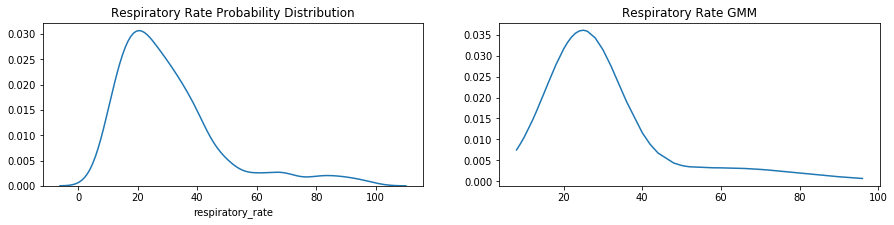

In [14]:
# respiratory rate feature
d3 = {'k':2, 'mu':[25.0, 85.0], 'sig':[10,10]}
y3 = gaussian_mixture_model(respiratory_rate, d3, "Respiratory Rate")

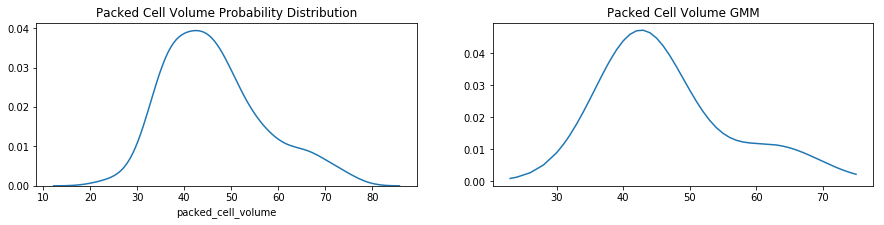

In [15]:
# respiratory rate feature
d4 = {'k':2, 'mu':[45.0, 65.0], 'sig':[10,10]}
y4 = gaussian_mixture_model(packed_cell_volume, d4, "Packed Cell Volume")

### It can be seen that our EM algorithm implementation did a decent job at creating GMMs

### This can most likely be attributed to the initial values of mu and sigma